In [3]:
'''
Neural Network w/ graph-convolution layers and w/ subset sharing layers w/ simple 2D random point clouds
'''
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from random import randrange
from numpy import linalg as LA
%matplotlib inline

# Generate random point clouds
def random_cloud(batch_size,n_pts,dim,coord_range=[-1,1]):
    return np.random.uniform(low=coord_range[0],high=coord_range[1],size=(batch_size,n_pts,dim))

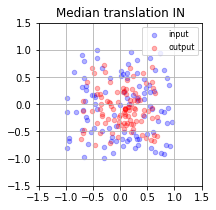

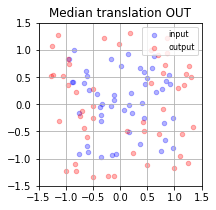

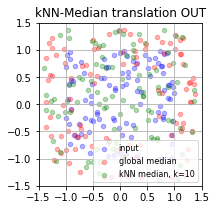

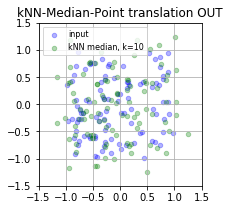

In [4]:
'''
Translation to the median: translate each particle towards the median w/ constant magnitude
'''

# inward
def T_median_A(X_in):
    eps = 1e-8
    T_val = .3
    median = np.median(X_in,axis=1,keepdims=True)
    dX = median-X_in
    dX_N = dX/(LA.norm(dX,axis=2,keepdims=True)+eps)
    return X_in + T_val*dX_N
    
# 2D example
test = random_cloud(1,100,2)
test_X = T_median_A(test)
fig = plt.figure()
fig.set_size_inches(3,3)
ax1 = fig.add_subplot(1,1,1,aspect='equal')
ax1.set_ylim([-1.5,1.5])
#ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.set_xlim([-1.5,1.5])
inp = ax1.scatter(test[0,:,0],test[0,:,1],color='b',s=20,alpha=.3)
out = ax1.scatter(test_X[0,:,0],test_X[0,:,1],color='r',s=20,alpha=.3)
plt.legend((inp,out),('input', 'output'),scatterpoints=1,loc='best',fontsize=8)
plt.xticks(np.arange(-1.5,1.6,.5))
plt.yticks(np.arange(-1.5,1.6,.5))
plt.grid(True)
plt.title("Median translation IN")
plt.show()

# outward
def T_median_B(X_in):
    eps = 1e-8
    T_val = .4
    median = np.median(X_in,axis=1,keepdims=True)
    dX = median-X_in
    dX_N = dX/(LA.norm(dX,axis=2,keepdims=True)+eps)
    return X_in - T_val*dX_N

# 2D example
test = random_cloud(1,50,2)
test_X = T_median_B(test)
fig = plt.figure()
fig.set_size_inches(3,3)
ax1 = fig.add_subplot(1,1,1,aspect='equal')
ax1.set_ylim([-1.5,1.5])
#ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.set_xlim([-1.5,1.5])
inp = ax1.scatter(test[0,:,0],test[0,:,1],color='b',s=20,alpha=.3)
out = ax1.scatter(test_X[0,:,0],test_X[0,:,1],color='r',s=20,alpha=.3)
plt.legend((inp,out),('input', 'output'),scatterpoints=1,loc='best',fontsize=8)
plt.xticks(np.arange(-1.5,1.6,.5))
plt.yticks(np.arange(-1.5,1.6,.5))
plt.grid(True)
plt.title("Median translation OUT")
plt.show()


'''
Translation to the kNN-median: translate each particle in the direction of the median of the kNN w/ constant magnitude
'''

from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import kneighbors_graph

def T_median_kNN(X_in,k):
    eps = 1e-8
    T_val = .4
    b = X_in.shape[0]
    n = X_in.shape[1]
    dim = X_in.shape[2]
    X_out = np.zeros((b,n,dim),dtype=np.float32)
    #nn = NearestNeighbors(n_neighbors=k, algorithm='ball_tree')
    for i in range(b):
        #indices = nn.fit(X_in[i]).kneighbors(X_in[i],return_distance=False)
        indices = kneighbors_graph(X_in[i],k,include_self=True).indices.reshape([n,k])
        for j in range(n):
            kNN_j = [X_in[i,r] for r in indices[j]]
            median_j = np.median(kNN_j,axis=0)
            dX_j = median_j-X_in[i,j]
            dX_jN = dX_j/(LA.norm(dX_j)+eps)
            X_out[i,j] = X_in[i,j] - T_val*dX_jN
    return X_out

# 2D example
test = random_cloud(1,100,2)
test_X = T_median_B(test)
test_kNN = T_median_kNN(test,10)
fig = plt.figure()
fig.set_size_inches(3,3)
ax1 = fig.add_subplot(1,1,1,aspect='equal')
ax1.set_ylim([-1.5,1.5])
ax1.set_xlim([-1.5,1.5])
inp = ax1.scatter(test[0,:,0],test[0,:,1],color='b',s=20,alpha=.3)
out_1 = ax1.scatter(test_X[0,:,0],test_X[0,:,1],color='r',s=20,alpha=.3)
out_2 = ax1.scatter(test_kNN[0,:,0],test_kNN[0,:,1],color='green',s=20,alpha=.3)
plt.legend((inp,out_1,out_2),('input', 'global median','kNN median, k=10'),scatterpoints=1,loc='best',fontsize=8)
plt.xticks(np.arange(-1.5,1.6,.5))
plt.yticks(np.arange(-1.5,1.6,.5))
plt.grid(True)
plt.title("kNN-Median translation OUT")
plt.show()


'''
Translation to the kNN-median: translate each particle exactly to the median point of the kNN
(magnitude is not constant, also actually translate in the opposite direction of the median again. Juest easier to visualize)
'''
def T_median_point_kNN(X_in,k):
    b = X_in.shape[0]
    n = X_in.shape[1]
    dim = X_in.shape[2]
    X_out = np.zeros((b,n,dim),dtype=np.float32)
    #nn = NearestNeighbors(n_neighbors=k, algorithm='ball_tree')
    for i in range(b):
        indices = kneighbors_graph(X_in[i],k,include_self=True).indices.reshape([n,k])
        #indices = nn.fit(X_in[i]).kneighbors(X_in[i],return_distance=False)
        for j in range(n):
            kNN_j = [X_in[i,r] for r in indices[j]]
            median_j = np.median(kNN_j,axis=0)
            dX_j = median_j-X_in[i,j]
            #dX_jN = dX_j/(LA.norm(dX_j)+eps)
            X_out[i,j] = X_in[i,j] - dX_j
    return X_out

# 2D example
test = random_cloud(1,100,2)
#test_X = T_median_B(test)
test_kNN = T_median_point_kNN(test,10)
fig = plt.figure()
fig.set_size_inches(3,3)
ax1 = fig.add_subplot(1,1,1,aspect='equal')
ax1.set_ylim([-1.5,1.5])
ax1.set_xlim([-1.5,1.5])
inp = ax1.scatter(test[0,:,0],test[0,:,1],color='b',s=20,alpha=.3)
#out_1 = ax1.scatter(test_X[0,:,0],test_X[0,:,1],color='r',s=20,alpha=.3)
out_2 = ax1.scatter(test_kNN[0,:,0],test_kNN[0,:,1],color='green',s=20,alpha=.3)
plt.legend((inp,out_2),('input','kNN median, k=10'),scatterpoints=1,loc='best',fontsize=8)
plt.xticks(np.arange(-1.5,1.6,.5))
plt.yticks(np.arange(-1.5,1.6,.5))
plt.grid(True)
plt.title("kNN-Median-Point translation OUT")
plt.show()

In [8]:
'''
OVERLAPPING SUBSETS/ SUBSET SHARING
description: for each particle in the set build a subset that contains its NN. Then use a set layer 
but with different set of weights depending on how many subsets each pair of particles share. 
For example, use a set of weights for all the pairs that share one subset, another set of weights for the pairs 
of particles that share two subsets, etc. You set a threshold so that pairs that share a number of subsets 
above the threshold all use the same set of weights.
'''

'''
Load and pre-process (adjacency) data
replace with path to input
'''
batch_1 = np.load('./saved_data/batch_1.npy')

# -----
# NN-median direction (10), fixed magnitude(0.4)
# -----

#batch_1_kNN = np.load('./saved_data/batch_1_T_kNN.npy')
#batch_1_kNN_a = T_median_kNN(batch_1,10)
#np.save('./saved_data/batch_1_kNN_a',batch_1_kNN_a)
batch_1_kNN_a = np.load('./saved_data/batch_1_kNN_a.npy')

# -----
# NN-median direction (10), magnitude = median point
# -----

#batch_1_kNN_point_1 = np.load('./saved_data/batch_1_kNN_point_1.npy')
#batch_1_kNN_point_a = T_median_point_kNN(batch_1,10)
#np.save('./saved_data/batch_1_kNN_point_a',batch_1_kNN_point_a)
#batch_1_kNN_point_a = np.load('./saved_data/batch_1_kNN_point_a.npy')

In [9]:
'''
DENSE ADJACENCY 
• subset sharing
• GC (graph-convolution layer)
'''

def adjacency(X_in,k):
    b = X_in.shape[0]
    n = X_in.shape[1]
    X_out = np.zeros([b,n,n])
    for i in range(b):
        X_out[i] = kneighbors_graph(X_in[i],k, mode='connectivity', include_self=True).toarray()
    return X_out

#A_batch_1 = adjacency(batch_1,10)
#np.save("./saved_data/A_batch_1",A_batch_1)
#A_batch_1 = np.load("./saved_data/A_batch_1.npy")

#A30_batch_1 = adjacency(batch_1,30)
#np.save("./saved_data/A30_batch_1",A30_batch_1)
#A30_batch_1 = np.load("./saved_data/A30_batch_1.npy")

# normalize adjacency matrix
def norm_A(A_in):
    eps = 1e-8
    b = A_in.shape[0]
    n = A_in.shape[1]
    X_out = np.zeros([b,n,n])
    for k in range(b):
        D = np.diag(1./(np.sqrt(np.sum(A_in[k],axis=1))+eps))
        X_out[k] = np.matmul(np.matmul(D,A_in[k]),D)
    return X_out    

#A_batch_1_norm = norm_A(A_batch_1) 

In [10]:
'''
Pre-process data: subsets
'''
# Convert np array to one-hot representation
def one_hot(A):
    A_1 = A.astype(int)
    return np.eye(np.max(A_1)+1, dtype=np.float32)[A_1]
    
# Let's do the dirty job at pre-processing stage, so don't need to implement it in TF
# takes as input adjacency matrix and returns a tensor of masks (to be dotted with a tensor of weights)
def subset_overlap(A, n_weights_max=3):
    n = A.shape[0]
    out = np.zeros([n, n], dtype=np.float32)
    for i in range(n):
        for j in range(i+1):
            out[i,j] = out[j,i] = (A[:,i] + A[:,j] == 2).sum() # number of subsets ij share
    out[out > n_weights_max-1] = n_weights_max-1 # threshold on number of parameters
    #out = one_hot(out) # one-hot rep (diag terms just renormalize diagonal weights)
    #return np.transpose(out,(2,0,1))
    return out

def subsets(A_in,n_max):
    b = A_in.shape[0]
    n = A_in.shape[1]
    X_out = np.zeros([b,n_max,n,n])
    for i in range(b):
        X_out[i] = subset_overlap(A_in[i], n_weights_max=n_max)
    return X_out        

In [70]:
'''
SPARSE ADJACENCY MATRICES FOR SUBSET-SHARING LAYER + avg/max normalization
STILL INCOMPLETE!
'''
from scipy.sparse import csr_matrix, find

# this returns a sparse matrix (only the upper triangle, it's symmetric) containing the number of subsets ij share
def subset_overlap_CRS(X_in,k,n_max=3):
    shape_in = X_in.shape
    X_out = list()
    for b in range(shape_in[0]):
        NN = kneighbors_graph(X_in[b],k,include_self=True)
        data, row_ind, col_ind = list(), list(), list()
        col_ind = list()
        for i in range(shape_in[1]):
            for j in range(i+1):
                share = ((NN.getcol(i)+NN.getcol(j)) == 2).sum() # number of subsets ij share
                if share >= n_max: share = n_max # ignore zero sharing for now
                if share != 0:
                    data.append(share)
                    row_ind.append(i)
                    col_ind.append(j)
        X_out.append(csr_matrix((data, (row_ind, col_ind))))
    return X_out   

test = subset_overlap_CRS(batch_1[:2],10,n_max=3)

# list with shape (n_max,b,n,sharing)
# for each set of weights and batch, selects the particles 
# takes as input the output of subset_overlap_CRS
def subset_alist(X_in,n_max):
    b = len(X_in)
    n = X_in[0].shape[0]
    out_k = list()
    for k in range(1,n_max+1):
        out_i = list()
        for i in range(b):
            out_j = list()
            for j in range(n):
                out_j.append((X_in[i]==k).getrow(j).nonzero()[1])
            out_i.append(out_j)
        out_k.append(out_i)
    return out_k
# ..should put it now in a form suitable for TF and get average or max
# is this an efficient way?

In [96]:
'''
SPARSE ADJACENCY MATRIX FOR GRAPH-CONVOLUTION LAYER
scikit learn gives a CRS sparse adjacency, TF takes COO sparse
also return adjacency lists
'''

from sklearn.neighbors import kneighbors_graph
from sklearn.neighbors import NearestNeighbors

# Example
X = batch_1[0]
#test1 = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(X).kneighbors(X,return_distance=False).nonzero()
#in_1 = np.column_stack(test1)
test1 = kneighbors_graph(X,10,include_self=True)
indices1 = np.column_stack(test1.nonzero())
values1 = test1.data

# returns indices of non-zero elements, to be used in tf.SparseTensor
def adjacency_COO(X_in,k):
    shape_in = X_in.shape
    X_out = np.zeros([shape_in[0],shape_in[1]*k,shape_in[2]])
    for b in range(shape_in[0]):
        X_out[b] = np.column_stack(kneighbors_graph(X_in[b],k,include_self=True).nonzero())
    return X_out

# returns adjacency lists
def adjacency_list(X_in,k):
    shape_in = X_in.shape
    X_out = np.zeros([shape_in[0],shape_in[1],k],dtype=np.int32)
    for b in range(shape_in[0]):
        X_out[b] = kneighbors_graph(X_in[b],k,include_self=True).indices.reshape([shape_in[1],k])
    return X_out

In [ ]:
'''
avg/max norm in TF for GC
'''
# tf.gather works for one batch and takes the adjacency list. Need to use gather_nd for the batched version.
# adjacency list to proper index list for gather_nd
def alist_to_indexlist(alist):
    b = alist.shape[0] # batch size
    n = alist.shape[1] # set size
    k = alist.shape[2] # number of nn
    id1 = np.reshape(np.arange(b),[b,1])
    id1 = np.tile(id1,n*k).flatten()
    out = np.stack([id1,alist.flatten()],axis=1)
    return out

test_1 = adjacency_list(batch_1[:10],10)
test_2 = alist_to_indexlist(test_1)

In [61]:
'''
Subset layers
'''

'''
batch multiplications
'''
# T1=(b,n,k)|T2=(k,r)
# Tout=(b,n,r)
def left_mult(T1,T2):
    Tout = tf.einsum('ijl,lq->ijq',T1,T2)
    return Tout

# T1=(m,n)|T2=(b,n,k)
# Tout=(b,m,k)
def right_mult(T1,T2):
    Tout = tf.einsum('ij,ljq->liq',T1,T2)
    return Tout

# T1=(b,p,n,n)|T2=(b,n,k)|T3=(p,k,r)|p=# of weight sets,n=set size|b=mini-batch size|k/r=in/out channels
# Tout=(b,n,r)
def subset_mult(T1,T2,T3):
    Tout = tf.einsum('lijm,lmy,iyq->ljq',T1,T2,T3)
    return Tout

'''
SUBSET LAYER w/ SUBSET SHARING
'''
def subset_layer(X_in,X_w_mask,L,G,activation=tf.identity,dropout=False,keep_prob=1.,batch_norm=False,gamma=0.,beta=0.):
    # average norm the input
    dim = tf.shape(X_in)
    b = dim[0]; n = dim[1];
    mean_ = tf.reduce_mean(X_in,axis=1,keep_dims=True)
    X_in_norm = X_in - tf.matmul(tf.ones([b,n,1],tf.float32),mean_)
    # weights
    X_1 = left_mult(X_in_norm,L) + subset_mult(X_w_mask,X_in_norm,G)
    X_2 = X_1
    if batch_norm:
        eps = 1e-8
        m,v = tf.nn.moments(X_1,axes=[0],keep_dims=True)
        X_1_hat = (X_1 - m) / tf.sqrt(v + eps)
        X_2 = X_1_hat * gamma + beta
    X_3 = activation(X_2)
    X_out = X_3
    # dropout (simultaneous along set dimension)
    if dropout:
        k_out = tf.shape(L)[1]
        X_out = tf.nn.dropout(X_3,keep_prob,noise_shape=[b,1,k_out])
    return X_out

'''
Subsets on the fly
'''
def next_minibatch(In,Truth,A,batch_size,n_max):
    if len(In) != len(Truth) or len(In) != len(A)  :
        raise ValueError('Inputs do not have the same dimension')
    index_list = np.random.randint(len(In), size=batch_size)
    batch_In = np.array([In[i] for i in index_list])
    batch_Truth = np.array([Truth[i] for i in index_list])
    batch_A = np.array([A[i] for i in index_list])
    batch_subsets = subsets(batch_A,n_max)
    return [batch_In,batch_Truth,batch_subsets]


'''
SUBSET LAYER w/ ADJACENCY (graph-convolution)
A_in = normalized batch of adjacency matrices
'''
# T1=(b,n,n)|T2=(b,n,k)|T3=(k,r)
# Tout=(b,n,r)
def A_mult(T1,T2,T3):
    Tout = tf.einsum('ijm,imy,yq->ijq',T1,T2,T3)
    return Tout

def graph_subset_layer(X_in,A_in,L,G,activation=tf.identity,dropout=False,keep_prob=1.):
    # average norm the input
    dim = tf.shape(X_in)
    b = dim[0]; n = dim[1];
    mean_ = tf.reduce_mean(X_in,axis=1,keep_dims=True)
    X_in_norm = X_in - tf.matmul(tf.ones([b,n,1],tf.float32),mean_)
    # weights
    X_1 = left_mult(X_in_norm,L) + A_mult(A_in,X_in_norm,G)
    X_2 = activation(X_1)
    X_out = X_2
    # dropout (simultaneous along set dimension)
    if dropout:
        k_out = tf.shape(L)[1]
        X_out = tf.nn.dropout(X_2,keep_prob,noise_shape=[b,1,k_out])
    return X_out


'''
SUBSET LAYER w/ ADJACENCY (graph-convolution)
max/avg normalization, index_list = nn
'''
def graph_subset_layer_beta(X_in,index_list,L,G,space_dim,activation=tf.identity,dropout=False,keep_prob=1.):
    # average norm the input
    dim = tf.shape(X_in)
    b = dim[0]; n = dim[1]
    X_1 = tf.reshape(tf.gather_nd(X_in,index_list),[b,n,10,space_dim])
    #X_2 = tf.reduce_mean(X_1,axis=2)
    X_2 = tf.reduce_max(X_1,axis=2)
    X_3 = left_mult(X_in,L) + left_mult(X_2,G)
    X_4 = activation(X_3)
    X_out = X_4
    # dropout (simultaneous along set dimension)
    if dropout:
        k_out = tf.shape(L)[1]
        X_out = tf.nn.dropout(X_4,keep_prob,noise_shape=[b,1,k_out])
    return X_out

In [23]:
'''
Original set layer v1
'''
# eq.5 of "deep-learning with sets and point-clouds"
def set_layer(X_in,W,B,activation=tf.identity,dropout=False,keep_prob=1.):
    # get dimensions: mini-batch size, set size, input channels
    dim = tf.shape(X_in)
    b = dim[0]; n = dim[1]; k = dim[2]
    # output channels
    k_out = tf.shape(W)[1] 
    # process input
    #max_ = tf.reduce_max(X_in,axis=1,keep_dims=True)
    mean_ = tf.reduce_mean(X_in,axis=1,keep_dims=True)
    X_1 = X_in - tf.matmul(tf.ones([b,n,1],tf.float32),mean_)
    X_2 = tf.reshape(X_1,[b*n,k])
    X_3 = tf.matmul(X_2,W) + B        
    X_4 = tf.reshape(activation(X_3),[b,n,k_out])
    out = X_4
    # dropout (simultaneous along set dimension)
    if dropout:
        out = tf.nn.dropout(X_4,keep_prob,noise_shape=[b,1,k_out])
    return out


'''
Original set layer v2
'''
def full_set_layer(X_in,L,G,activation=tf.identity,dropout=False,keep_prob=1.):
    dim = tf.shape(X_in)
    b = dim[0]; n = dim[1]; k = dim[2]
    k_out = tf.shape(L)[1] 
    # process input
    X_1 = left_mult(X_in,L)
    X_2 = left_mult(X_in,G)
    ones = tf.ones([n,n])
    X_3 = X_1 + right_mult(ones,X_2)
    X_4 = activation(X_3)
    out = X_4
    # dropout (simultaneous along set dimension)
    if dropout:
        out = tf.nn.dropout(X_4,keep_prob,noise_shape=[b,1,k_out])
    return out

'''
Mini-batch
'''
def SL_next_minibatch(In,Truth,batch_size):
    if len(In) != len(Truth):
        raise ValueError('Inputs do not have the same dimension')
    index_list = np.random.randint(len(In), size=batch_size)
    batch_In = np.array([In[i] for i in index_list])
    batch_Truth = np.array([Truth[i] for i in index_list])
    return [batch_In,batch_Truth]

In [62]:
'''
Neural Network
'''
# initialize params
def w_variable(shape):
    initial = tf.truncated_normal(shape, stddev=1e-3)
    return tf.Variable(initial)

def b_variable(shape):
    initial = tf.constant(1e-2, shape=shape)
    return tf.Variable(initial)

# in/out channels
k_in = 2
k_out = 2

# max number of parameter sets for partial sharing
#n_params = 10

keep_prob = tf.placeholder(tf.float32)
X_input = tf.placeholder(tf.float32, shape=[50,100,k_in])
X_truth = tf.placeholder(tf.float32, shape=[50,100,k_out])

index_list = tf.placeholder(tf.int32, shape=[50*100*10,2]) # (batch_size*set_size*nn,2)
#A_input = tf.placeholder(tf.float32, shape=[50,100,100])
#X_weight_mask = tf.placeholder(tf.float32, shape=[50,n_params,100,100])


'''
Layer 1
'''
k1 = 256 # output channels
L1 = w_variable([k_in,k1])
#G1 = w_variable([n_params,k_in,k1])
#out1 = subset_layer(X_input,X_weight_mask,L1,G1,activation=tf.nn.relu,dropout=True,batch_norm=False)

G1 = w_variable([k_in,k1])
out1 = graph_subset_layer_beta(X_input,index_list,L1,G1,k_in,activation=tf.nn.relu,dropout=True)

#out1 = graph_subset_layer(X_input,A_input,L1,G1,activation=tf.nn.relu,dropout=True)

#W1 = w_variable([k_in,k1])
#B1 = w_variable([k1])
#G1 = w_variable([k_in,k1])

#out1 = set_layer(X_input,W1,B1,activation=tf.nn.relu,dropout=True)
#out1 = full_set_layer(X_input,W1,G1,activation=tf.nn.relu,dropout=True)



'''
Layer 2
'''
k2 = 256 # output channels
L2 = w_variable([k1,k2])
#G2 = w_variable([n_params,k1,k2])
#out2 = subset_layer(out1,X_weight_mask,L2,G2,activation=tf.nn.relu,dropout=True,batch_norm=False)

G2 = w_variable([k1,k2])
out2 = graph_subset_layer_beta(out1,index_list,L2,G2,k1,activation=tf.nn.relu,dropout=True)


#out2 = graph_subset_layer(out1,A_input,L2,G2,activation=tf.nn.relu,dropout=True)

#W2 = w_variable([k1,k2])
#B2 = w_variable([k2])
#G2 = w_variable([k1,k2])

#out2 = set_layer(out1,W2,B2,activation=tf.nn.relu,dropout=True)
#out2 = full_set_layer(out1,W2,G2,activation=tf.nn.relu,dropout=True)


# '''
# Layer 3
# '''
# k3 = 256 # output channels
# L3 = w_variable([k2,k3])
# #G3 = w_variable([n_params,k2,k3])
# #out3 = subset_layer(out2,X_weight_mask,L3,G3,activation=tf.nn.relu,dropout=False,batch_norm=False)

# G3 = w_variable([k2,k3])
# out3 = graph_subset_layer(out2,A_input,L3,G3,activation=tf.nn.relu,dropout=True)



'''
Output layer
'''
L_out = w_variable([k2,k_out])
#G_out = w_variable([n_params,k2,k_out])
#readout = subset_layer(out2,X_weight_mask,L_out,G_out,activation=tf.identity,dropout=False,batch_norm=False)

G_out = w_variable([k2,k_out])
readout = graph_subset_layer_beta(out2,index_list,L_out,G_out,k2,activation=tf.identity,dropout=False)


#readout = graph_subset_layer(out2,A_input,L_out,G_out,activation=tf.identity,dropout=False)

#W_out = w_variable([k2,k_out])
#B_out = w_variable([k_out])
#G_out = w_variable([k2,k_out])

#readout = set_layer(out2,W_out,B_out,activation=tf.identity,dropout=False)
#readout = full_set_layer(out2,W_out,G_out,activation=tf.identity,dropout=False)


'''
Loss Function
'''
# L2-distance 
loss = tf.reduce_mean(tf.reduce_mean(tf.reduce_sum(tf.square(readout-X_truth),axis=2),axis=1),axis=0)

# L1-distance 
#loss = tf.reduce_mean(tf.reduce_mean(tf.reduce_sum(tf.abs(readout-X_truth),axis=2),axis=1),axis=0)


'''
Optimization
'''
train_step = tf.train.AdamOptimizer(1e-2).minimize(loss)
#train_step = tf.train.GradientDescentOptimizer(1e-3).minimize(loss)
#train_step = tf.train.AdamOptimizer(learning_rate=5e-5,beta1=0.9,beta2=0.99).minimize(loss) # tweak adaptive learning

# # Gradient descent w/ exponential decay 
# global_step = tf.Variable(0, trainable=False)
# starter_learning_rate = 1e-5
# learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 500,0.9, staircase=True)
# train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

# # AdamOptimizer w/ piecewise learning rate
# global_step = tf.Variable(0, trainable=False)
# boundaries = [100000]
# values = [1e-6,1e-7]
# learning_rate = tf.train.piecewise_constant(global_step, boundaries, values)
# train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)

In [ ]:
'''
TRAINING
'''
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

import time
from IPython import display

n_iter = 4000
mini_batch_size = 50

t = list()
loss_vals = list()

for i in range(n_iter):
    #batch = SL_next_minibatch(batch_1,batch_1_kNN,mini_batch_size)
    #batch = graph_next_minibatch(batch_1,batch_1_kNN_point_1,A_batch_1_norm,mini_batch_size)
    batch = SL_next_minibatch(batch_1,batch_1_kNN_a,mini_batch_size)
    alist = adjacency_list(batch[0],10)
    ilist = alist_to_indexlist(alist)
    if i%10 == 0:
        t.append(i)
        #this_loss = sess.run(loss,feed_dict={X_input: batch[0], X_truth: batch[1], X_weight_mask: batch[2], keep_prob: 1.})
        #this_loss = sess.run(loss,feed_dict={X_input: batch[0], X_truth: batch[1], keep_prob: 1.})
        #this_loss = sess.run(loss,feed_dict={X_input: batch[0], X_truth: batch[1], A_input: batch[2], keep_prob: 1.})
        this_loss = sess.run(loss,feed_dict={X_input: batch[0], X_truth: batch[1], index_list: ilist, keep_prob: 1.})
        loss_vals.append(this_loss)
        #print this_loss
        #plt.xscale('log')
        plt.yscale('log')
        plt.grid(True)
        plt.plot(t,loss_vals,'b-')
        plt.scatter(t,loss_vals,color='black',s=20,alpha=.3)
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.grid(True)
        if len(t) > 1:
            plt.title('i = '+str(t[-1])+' | Loss = '+str(loss_vals[-1])+' ('+str(loss_vals[-2])+')')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(1)    
    
    #train_step.run(feed_dict={X_input: batch[0], X_truth: batch[1], X_weight_mask: batch[2], keep_prob: .8})
    #train_step.run(feed_dict={X_input: batch[0], X_truth: batch[1], keep_prob: .8})
    #train_step.run(feed_dict={X_input: batch[0], X_truth: batch[1], A_input: batch[2], keep_prob: .8})
    train_step.run(feed_dict={X_input: batch[0], X_truth: batch[1], index_list: ilist, keep_prob: .8})

In [159]:
'''
save loss function
'''
# Save loss vals
#loss_7 = np.array([t,loss_vals])
#np.save('./saved_data/loss_7',loss_7)

'''
------------------
'''
# kNN-point*1|subset-layer|relu|n_params = 10
loss_1 = np.load('./saved_data/loss_1.npy')

# kNN-point*1|subset-layer|relu|n_params = 1
loss_2 = np.load('./saved_data/loss_2.npy')

# kNN-point*1|subset-layer|relu|n_params = 1|no-mean-subtraction
loss_3 = np.load('./saved_data/loss_3.npy')

# kNN-point*1|set-layer mean-norm|relu
loss_4 = np.load('./saved_data/loss_4.npy')

# kNN-point*1|set-layer full|relu (equivalent to subset-layer|relu|n_params = 1)
loss_5 = np.load('./saved_data/loss_5.npy')

'''
------------------
'''
# kNN-fixed-magitude|set-layer mean-norm|relu
loss_6 = np.load('./saved_data/loss_6.npy')

# kNN-fixed-magitude|subset-layer w/ mean subtraction|relu|n_params = 10
loss_7 = np.load('./saved_data/loss_7.npy')

In [157]:
'''
------------------
'''
#loss_9 = np.array([t,loss_vals])
#np.save('./saved_data/loss_9',loss_9)

# kNN-fixed-magitude|GRAPH-subset-layer w/ mean subtraction|relu
loss_8 = np.load('./saved_data/loss_8.npy')

# kNN-point*1|GRAPH-subset-layer w/ mean subtraction|relu
loss_9 = np.load('./saved_data/loss_9.npy')

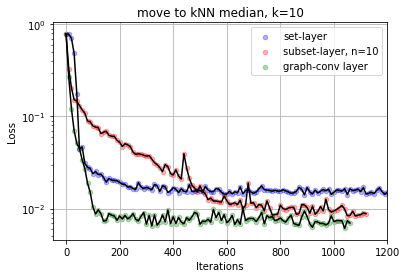

In [160]:
plt.yscale('log')
plt.grid(True)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.xlim([-50,1200])
d1_a = plt.scatter(loss_4[0],loss_4[1],color='blue',s=20,alpha=.3)
d1_b = plt.plot(loss_4[0],loss_4[1],color='black')
d2_a = plt.scatter(loss_1[0],loss_1[1],color='red',s=20,alpha=.3)
d2_b = plt.plot(loss_1[0],loss_1[1],color='black')
d3_a = plt.scatter(loss_9[0],loss_9[1],color='green',s=20,alpha=.3)
d3_b = plt.plot(loss_9[0],loss_9[1],color='black')
plt.title('move to kNN median, k=10')
plt.legend((d1_a,d2_a,d3_a),('set-layer','subset-layer, n=10','graph-conv layer'),scatterpoints=1,loc='upper right',fontsize=10)
plt.show()

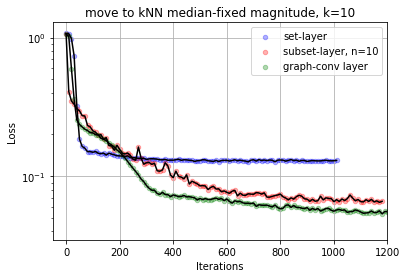

In [161]:
plt.yscale('log')
plt.grid(True)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.xlim([-50,1200])
d1_a = plt.scatter(loss_6[0],loss_6[1],color='blue',s=20,alpha=.3)
d1_b = plt.plot(loss_6[0],loss_6[1],color='black')
d2_a = plt.scatter(loss_7[0],loss_7[1],color='red',s=20,alpha=.3)
d2_b = plt.plot(loss_7[0],loss_7[1],color='black')
d3_a = plt.scatter(loss_8[0],loss_8[1],color='green',s=20,alpha=.3)
d3_b = plt.plot(loss_8[0],loss_8[1],color='black')
plt.title('move to kNN median-fixed magnitude, k=10')
plt.legend((d1_a,d2_a,d3_a),('set-layer','subset-layer, n=10','graph-conv layer'),scatterpoints=1,loc='upper right',fontsize=10)
plt.show()

In [59]:
test_batch_size = 50
in_test = random_cloud(test_batch_size,100,2)
A_test_1 = adjacency(in_test,10)
sub_test_1 = subsets(A_test_1,n_max=10)

#truth_test = T_median_point_kNN(in_test,10)
truth_test = T_median_kNN(in_test,10)
out_test = sess.run(readout,feed_dict={X_input: in_test, X_weight_mask: sub_test_1, keep_prob: 1.})
loss_test = np.mean(np.mean(np.sum(np.square(out_test-truth_test),axis=2),axis=1),axis=0)

L2 loss on test = 0.0662565


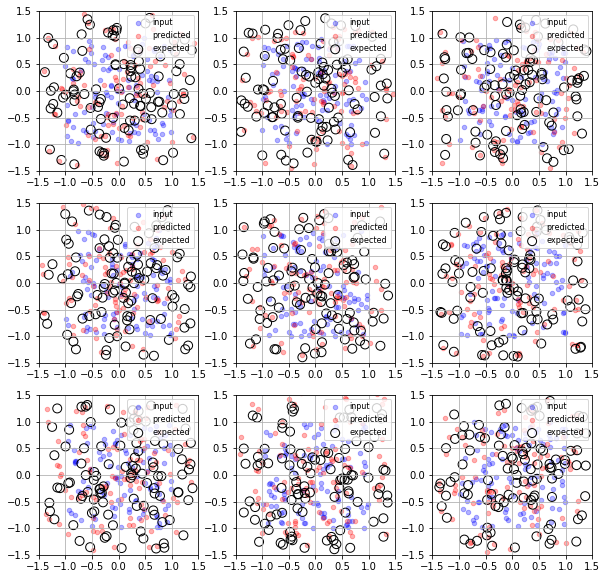

In [60]:
print 'L2 loss on test =', loss_test
fig = plt.figure()
fig.set_size_inches(10,10)
xylims = [-1.5,1.5]
for i in range(9):
    ax = fig.add_subplot(3,3,i+1,aspect='equal')
    ax.set_ylim(xylims)
    ax.set_xlim(xylims)
    inp = ax.scatter(in_test[i,:,0],in_test[i,:,1],color='blue',s=20,alpha=.3)
    out = ax.scatter(out_test[i,:,0],out_test[i,:,1],color='red',s=20,alpha=.3)
    tru = ax.scatter(truth_test[i,:,0],truth_test[i,:,1],edgecolors='black',s=80,facecolors='none')
    #plt.legend((inp,out,tru),('input', 'predicted', 'expected'),scatterpoints=1,loc='upper right',fontsize=8)
    plt.legend((inp,out,tru),('input','predicted', 'expected'),scatterpoints=1,loc='upper right',fontsize=8)
    plt.xticks(np.arange(xylims[0],xylims[1]+.1,.5))
    plt.yticks(np.arange(xylims[0],xylims[1]+.1,.5))
    plt.grid(True)
plt.show()